In [2]:
'''
Simple Gini Regressions
    
    Simple non parametric Gini regression
    Simple parametric Gini regression
    Comparison with statsmodels norm Hubert (robust estimation)
    Examples of estimations with outliers
'''
    
# Author: S. Mussard <stephane.mussard@unimes.fr>
# Github: 

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.optimize import minimize
from scipy.stats import norm

# Generate some points
n = 30 
x = np.arange(0,n) + np.random.rand(n)
y = np.arange(0,n)*2

# Non-parametric Gini regression
rank_x = ss.rankdata(x, method='average')
beta_gini = np.cov(y.T,rank_x.T)[0][1] / np.cov(x.T,rank_x.T)[0][1]
alpha_gini = np.mean(y) - beta_gini*np.mean(x)

# OLS
beta_ols = np.cov(y.T,x.T)[0][1] / np.cov(x.T,x.T)[0][1]
alpha_ols = np.mean(y) - beta_ols*np.mean(x)

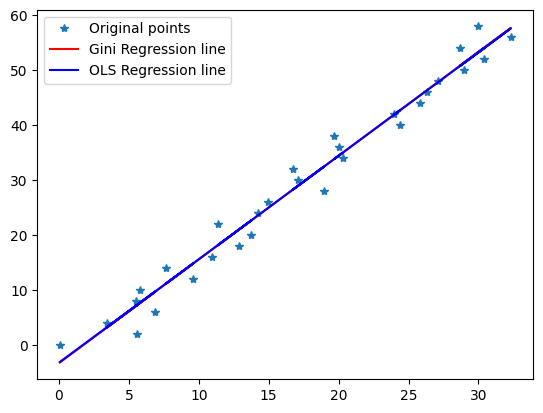

In [3]:
# Diagram
plt.plot(x, y, '*', label='Original points')
plt.plot(x, alpha_gini + x*beta_gini, 'r', label='Gini Regression line')
plt.plot(x, alpha_ols + x*beta_ols, 'b', label='OLS Regression line')
plt.legend()
plt.show()

In [ ]:
# Generate some points
x = np.arange(0,n) + np.random.rand(n)
y = np.arange(0,n)*2

# Outlier in x[19] 
x[19] = x[19]*4
# Try outlier in y[19]=38 : now y[19] = y[19]*10 (rank_x does not change)

# Non-parametric Gini regression
beta_gini = np.cov(y.T,rank_x.T)[0][1] / np.cov(x.T,rank_x.T)[0][1]
alpha_gini = np.mean(y) - beta_gini*np.mean(x)

# OLS
beta_ols = np.cov(y.T,x.T)[0][1] / np.cov(x.T,x.T)[0][1]
alpha_ols = np.mean(y) - beta_ols*np.mean(x)  

# Diagram
plt.plot(x, y, '+', label='Original points')
plt.plot(x[19], y[19], 'or', label='Outlier')
plt.plot(x, alpha_gini + x*beta_gini, 'r', label='Gini Regression')
plt.plot(x, alpha_ols + x*beta_ols, 'b', label='OLS Regression')
plt.legend()
plt.show()

In [ ]:
# reshape x and y
x = np.reshape(x,(n,1))
y = np.reshape(y,(n,1))
# put y, constant and x in matrix X
X = np.concatenate((y,np.ones((n,1)), x), axis = 1) 


In [ ]:
# Parametric Gini regression
def gini_param(coef, X):
    residuals = X[:, 0] - (coef * X[:, 1:]).sum(axis=1)
    rank_residuals = ss.rankdata(residuals, method='average')
    return 1/n*np.cov(residuals.T,rank_residuals.T)[0][1] # function to minimize

initial = [0, 0]
result = minimize(gini_param, initial, args=X)
alpha_gini_param = result.x[0]
beta_gini_param = result.x[1]
print("coefficient estimates",alpha_gini_param, beta_gini_param)
print("min function",result.fun) # min of the function on the points estimates

In [ ]:
# Output
print("coef. Gini non parametric:", alpha_gini, beta_gini)
print("coef. Gini parametric:", result.x)
print("coef. ols:", alpha_ols, beta_ols)
# Diagram
plt.plot(x, y, '+', label='Original points')
plt.plot(x[19], y[19], 'or', label='Outlier')
plt.plot(x, alpha_gini + x*beta_gini, 'r', label='Gini Regression non-param')
plt.plot(x, alpha_gini_param + x*beta_gini_param, 'k', label='Gini Regression param')
plt.plot(x, alpha_ols + x*beta_ols, 'b', label='OLS Regression')
plt.legend()
plt.show()


In [ ]:
# Load statsmodels for Huber robust estimation 
import statsmodels.api as sm
x_with_constant = sm.add_constant(x)
robust_model = sm.RLM(y, x_with_constant, M=sm.robust.norms.HuberT())
robust_model_results = robust_model.fit()
print(robust_model_results.params)


In [ ]:
# Diagram
plt.plot(x, y, '+', label='Original points')
plt.plot(x[19], y[19], 'or', label='Outlier')
plt.plot(x, alpha_gini + x*beta_gini, 'r', label='Gini Regression non-param')
plt.plot(x, alpha_gini_param + x*beta_gini_param, 'k', label='Gini Regression param')
plt.plot(x, alpha_ols + x*beta_ols, 'b', label='OLS Regression')
plt.plot(x, robust_model_results.params[0] + x*robust_model_results.params[1], 'g', label='Robust Regression')
plt.legend()
plt.show()

## Testing for linearity

In [ ]:
def linearity(y, x):
    rank_x = ss.rankdata(x, method='average')
    beta_gini = np.cov(y.T,rank_x.T)[0][1] / np.cov(x.T,rank_x.T)[0][1]
    alpha_gini = np.mean(y) - beta_gini*np.mean(x)
    residuals = y - alpha_gini - beta_gini*x
    rank_residuals = ss.rankdata(residuals, method='average')
    U = np.cov(x.T,rank_residuals.T)[0][1]
    return U

def jackknife(y, x):
    U_list = []
    n = len(x)
    for i in range (n):
        x_jack = np.delete(x, i, axis=0)
        y_jack = np.delete(y, i, axis=0)
        rank_xjack = ss.rankdata(x_jack, method='average')
        beta_gini = np.cov(y_jack.T,rank_xjack.T)[0][1] / np.cov(x_jack.T,rank_xjack.T)[0][1]
        alpha_gini = np.mean(y_jack) - beta_gini*np.mean(x_jack)
        residuals = y_jack - alpha_gini - beta_gini*x_jack
        rank_residuals = ss.rankdata(residuals, method='average')
        U = np.cov(x_jack.T,rank_residuals.T)[0][1]
        U_list.append(U)
    variance_U = (n-1)/n*(np.sum((U_list - np.mean(U_list))**2))
    stdev_U = np.sqrt(variance_U) 
    return stdev_U 

# Test of linearity:
u_statistics_coeff = linearity(y,x) / jackknife(y,x)
p_values_coeff = (1-norm.cdf(np.abs(u_statistics_coeff)))*2
print("p_value =", p_values_coeff)
